# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math

# ignore TF CPU logs, before importing tensorflow 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


import tensorflow as tf
import tensorflow.keras as keras 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import StandardScaler


# Display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Ignore verbose errors
tf.get_logger().setLevel('ERROR')




### Set Seed for consistent reproducibility 

In [2]:
import random as python_random

def reset_seeds(seed_val = 0):
   np.random.seed(seed_val) 
   python_random.seed(seed_val)
   tf.random.set_seed(seed_val)

reset_seeds()

### Load combined pre-processed datasets

In [3]:
train = pd.read_csv('../data/train_monthly.csv',sep='\t')
test = pd.read_csv('../data/test_monthly.csv',sep='\t')
val = pd.read_csv('../data/validation_monthly.csv',sep='\t')

Check for Nan Values

In [4]:
missing_values = train.isna().sum()

# Filter and print only the columns with non-zero missing values
non_zero_missing_values = missing_values[missing_values > 0]
print(non_zero_missing_values)

cdsd      1
dsnd     24
dyfg    167
dysd     24
dyts    167
emsd     24
evap    153
hdsd      7
mnpn    164
mxpn    164
wdmv    153
dtype: int64


In [5]:
train.describe()

Unnamed: 0        cdsd        cldd        dp01        dp10        dp1x  \
count   167.00000  166.000000  167.000000  167.000000  167.000000  167.000000   
mean     83.00000   12.846386    2.262275    6.185629    4.359281    0.616766   
std      48.35287   15.586605    6.451390    5.215388    4.220178    1.288207   
min       0.00000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      41.50000    0.000000    0.000000    2.000000    1.000000    0.000000   
50%      83.00000    2.450000    0.000000    5.000000    3.000000    0.000000   
75%     124.50000   29.000000    0.150000    9.000000    6.500000    1.000000   
max     166.00000   46.700000   40.500000   21.000000   19.000000    8.000000   

             dsnd        dsnw        dt00        dt32        dx32        dx70  \
count  143.000000  167.000000  167.000000  167.000000  167.000000  167.000000   
mean    11.069930    2.730539    0.071856   16.275449    1.161677    9.299401   
std     12.600945    3.611289    0.373342   12.236458    2.217992   12.038850   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    2.000000    0.000000    0.000000   
50%      4.000000    1.000000    0.000000   21.000000    0.000000    1.000000   
75%     25.000000    4.000000    0.000000   28.000000    1.000000   21.000000   
max     31.000000   18.000000    3.000000   31.000000   10.000000   31.000000   

             dx90  dyfg          dynt          dysd          dysn  dyts  \
count  167.000000   0.0  1.670000e+02  1.430000e+02  1.670000e+02   0.0   
mean     0.035928   NaN  2.007551e+07  2.006821e+07  2.007552e+07   NaN   
std      0.242780   NaN  4.050731e+04  3.913879e+04  4.050630e+04   NaN   
min      0.000000   NaN  2.001012e+07  2.001013e+07  2.001013e+07   NaN   
25%      0.000000   NaN  2.004066e+07  2.003567e+07  2.004067e+07   NaN   
50%      0.000000   NaN  2.007123e+07  2.006123e+07  2.007122e+07   NaN   
75%      0.000000   NaN  2.011066e+07  2.009117e+07  2.011067e+07   NaN   
max      2.000000   NaN  2.014123e+07  2.014122e+07  2.014122e+07   NaN   

               dyxp          dyxt        emnt         emsd        emsn  \
count  1.670000e+02  1.670000e+02  167.000000   143.000000  167.000000   
mean   2.007551e+07  2.007551e+07   -6.461677   339.244755  128.221557   
std    4.050649e+04  4.050703e+04    6.873905   452.926559  169.941712   
min    2.001011e+07  2.001010e+07  -20.000000     0.000000    0.000000   
25%    2.004067e+07  2.004067e+07  -12.200000     0.000000    0.000000   
50%    2.007121e+07  2.007120e+07   -6.700000    76.000000   51.000000   
75%    2.011066e+07  2.011068e+07   -1.100000   647.500000  229.000000   
max    2.014120e+07  2.014122e+07    6.100000  1880.000000  737.000000   

             emxp        emxt        evap         hdsd        htdd       mnpn  \
count  167.000000  167.000000   14.000000   160.000000  167.000000   3.000000   
mean    21.080838   20.927545  127.421429  1885.602500  338.413772  10.770000   
std     23.277115    7.414279   26.634049  1488.564259  193.900395   2.382939   
min      0.000000    8.300000   69.700000    12.300000   12.300000   8.090000   
25%      4.200000   13.900000  111.075000   286.550000  145.600000   9.830000   
50%     14.200000   21.700000  134.050000  1660.000000  377.800000  11.570000   
75%     27.550000   27.800000  146.825000  3348.625000  516.550000  12.110000   
max    136.400000   33.300000  159.800000  4366.000000  644.800000  12.650000   

            mxpn        prcp         snow        tavg        tmax        tmin  \
count   3.000000  167.000000   167.000000  167.000000  167.000000  167.000000   
mean   25.500000   60.256886   361.275449    7.014012   14.161677   -0.134551   
std     3.661857   76.428833   579.561640    6.730035    8.107926    5.404186   
min    22.020000    0.000000     0.000000   -2.810000    2.200000   -9.470000   
25%    23.590000    6.450000     0.000000    0.635000    6.390000   -

Check tavg data in Training data

In [6]:
train.loc[:,['date','tavg']][:5]

,date,tavg
0,2001-01,-1.50
1,2001-02,-1.50
2,2001-03,3.41
3,2001-04,2.91
4,2001-05,11.98


In [7]:
train.loc[:,['date','tavg']][-5:]

,date,tavg
162,2014-08,16.41
163,2014-09,14.51
164,2014-10,9.43
165,2014-11,4.45
166,2014-12,0.91


So we have monthly data available from 2001 Jan to 2014 Dec. Now let's see Test data. 

In [8]:
test.loc[:,['date','tavg']]

,date,tavg
0,2019-01,-0.10
1,2019-02,-3.52
2,2019-03,0.08
3,2019-04,5.30
4,2019-05,6.32
5,2019-06,13.09
6,2019-07,16.18
7,2019-08,16.84
8,2019-09,11.97
9,2019-10,5.37


### Check distribution of Average Temperatures

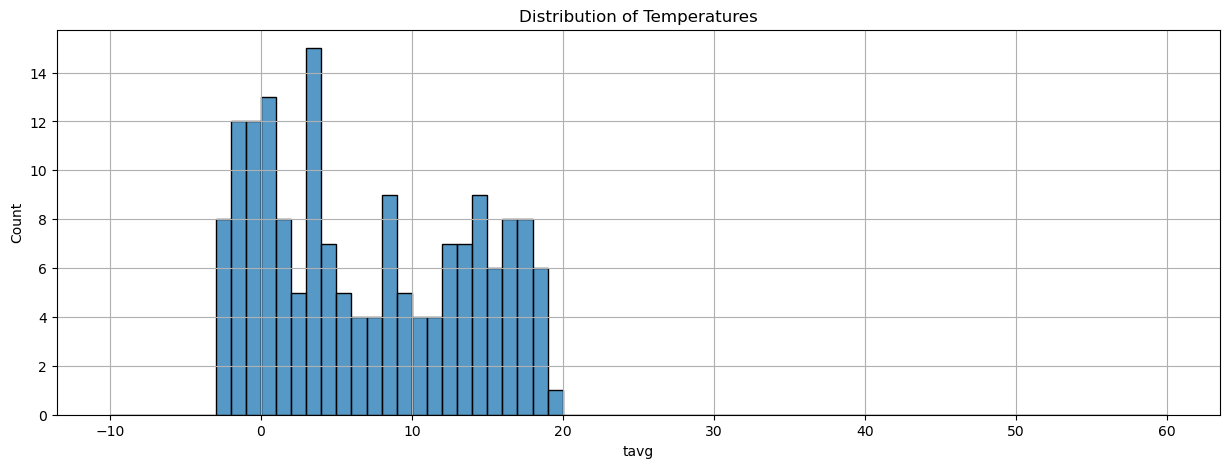

In [9]:
import seaborn as sns


plt.figure(figsize=(15, 5))
sns.histplot(train['tavg'],bins=[i for i in range(-10,61,1)], kde=False)
plt.title("Distribution of Temperatures")
plt.grid()
plt.show()

In [10]:
train.columns

Index(['Unnamed: 0', 'date', 'cdsd', 'cldd', 'dp01', 'dp10', 'dp1x', 'dsnd',
       'dsnw', 'dt00',
       ...
       'tc_loss_ha_Uruguay', 'tc_loss_ha_Uzbekistan', 'tc_loss_ha_Vanuatu',
       'tc_loss_ha_Venezuela', 'tc_loss_ha_Vietnam',
       'tc_loss_ha_Virgin Islands, U.S.', 'tc_loss_ha_Zambia',
       'tc_loss_ha_Zimbabwe', 'tc_loss_ha_Åland', 'tc_loss_ha_average'],
      dtype='object', length=1135)

In [11]:
# transformation for cyclical data. our monthly data is cyclical in nature due to seasons

def add_sin_cos_transformations_to_month(data):

    # Convert date column to datetime
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m')

    # Extract month from date
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year

    # Apply sine and cosine transformations to the month
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)



add_sin_cos_transformations_to_month(train)
add_sin_cos_transformations_to_month(test)
add_sin_cos_transformations_to_month(val)


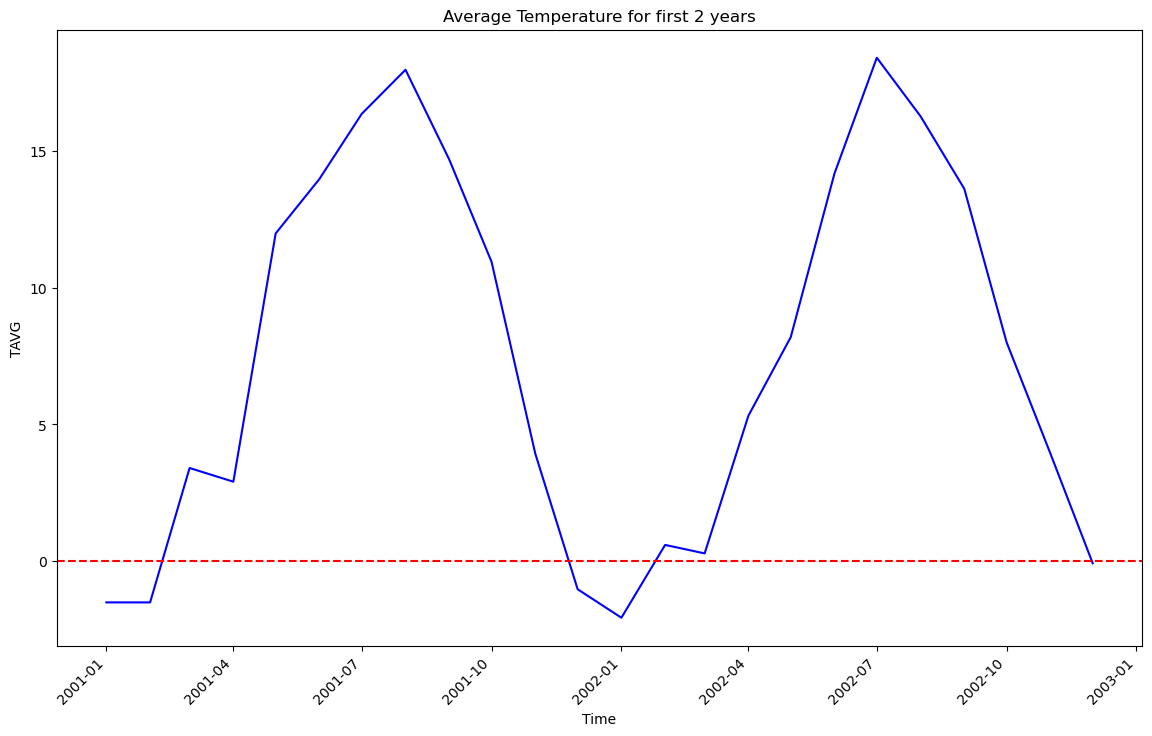

In [12]:

def plot_snow(df):
    fig, ax = plt.subplots(figsize=(14, 8))  # Corrected here
    
    # Interpolation
    x = df['date']
    y = df['tavg']
    
    
    ax.plot(x, y, color='b')  
    ax.set_title('Average Temperature for first 2 years')
    ax.set_xlabel('Time')
    ax.set_ylabel('TAVG')
    ax.axhline(y=0, color='r', linestyle='--',  label='Zero Line')  # Add horizontal line at y = 0
    plt.xticks(rotation=45, ha='right')

    plt.show()



plot_snow(train[:24])

### Add Plotly plot so we can  hover over it

In [13]:
import plotly.express as px

fig = px.line(train, x='date', y='tavg', title='Average Monthly Temperatures Over Time', labels={'tavg': 'Average Temperature in Celsius', 'date': 'Date'})
fig.show()

### Non-Time series model using Linear Regression

In [14]:
linear_regression_features = ['snow','dp10']

X_train = train[linear_regression_features]
y_train = train[['tavg']]


X_test = test[linear_regression_features]
y_test = test[['tavg']]

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



# Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [16]:
import matplotlib.pyplot as plt


# Predictions
y_pred = model.predict(X_test)

# Evaluation
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')




Root Mean Squared Error: 5.1301237114264095


In [17]:
y_test.head()

,tavg
0,-0.10
1,-3.52
2,0.08
3,5.30
4,6.32


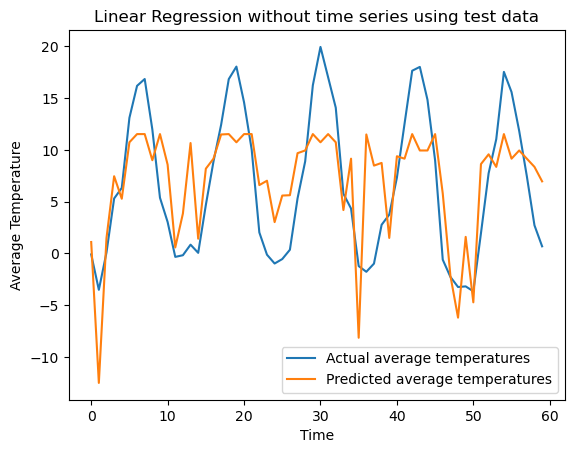

In [18]:
def plot_predictions(actual, predicted, xlabel, ylabel, title):
    plt.plot(actual,label='Actual average temperatures')
    plt.plot(predicted, label='Predicted average temperatures')

    plt.xlabel(xlabel)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()




def plot_predictions_train_test(actual_train, predicted_train, actual_test, predicted_test, xlabel, ylabel, title):
    fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

    # Plot training data
    ax[0].plot(actual_train, label='Actual average temperatures', color='blue')
    ax[0].plot(predicted_train, label='Predicted average temperatures', color='red', linestyle='--')
    ax[0].set_title('Training Data')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
    ax[0].legend()

    # Plot test data
    ax[1].plot(actual_test, label='Actual average temperatures', color='blue')
    ax[1].plot(predicted_test, label='Predicted average temperatures', color='red', linestyle='--')
    ax[1].set_title('Test Data')
    ax[1].set_xlabel(xlabel)
    ax[1].legend()

    # Set the main title for the entire figure
    fig.suptitle(title)

    plt.show()


plot_predictions(y_test, y_pred,"Time","Average Temperature","Linear Regression without time series using test data")

In [19]:
# Convert data to sequences to make Supervised learning possible

def create_sequences(data, window_size, seq_features, target_variable):
    """_summary_

    Args:
        data (_type_): test/train/validation data
        window_size (_type_): Number of preceding months in training set that will predict the target variable
        seq_features (_type_): features selected in the training data (which includes the target variable)
        target_variable (_type_): The variable to be predicted
    Returns:
        _type_: (X, y) where shape of X is (len(data) - window_size, window_size, seq_features) and shape of y is (window_size, 1)
    """
    xs, ys = [], []
    for i in range(len(data) - window_size):
        x = data[i:i+window_size] [seq_features].values
        y = data[i+window_size:i+window_size+1][target_variable].values # pick 1 row after
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


# Splits train, test and val data into sequential datasets, suitable for Time Series analysis
def create_sequential_datasets(train, test, val, window_size, lstm_features, target_variable):

    X_seq_train, y_seq_train = create_sequences(train, window_size,lstm_features,target_variable)
    X_seq_test, y_seq_test = create_sequences(test, window_size,lstm_features, target_variable)
    X_seq_val, y_seq_val = create_sequences(val, window_size,lstm_features, target_variable)

    return X_seq_train, y_seq_train, X_seq_test, y_seq_test, X_seq_val, y_seq_val


#### Test the functionality of create_sequences()

In [20]:
X_seq_train, y_seq_train = create_sequences(train, window_size=12,seq_features=['tavg','month','year','snow'],target_variable='tavg')

X_seq_train[:1], y_seq_train[:1]


(array([[[-1.500e+00,  1.000e+00,  2.001e+03,  6.610e+02],
         [-1.500e+00,  2.000e+00,  2.001e+03,  1.589e+03],
         [ 3.410e+00,  3.000e+00,  2.001e+03,  1.780e+02],
         [ 2.910e+00,  4.000e+00,  2.001e+03,  5.800e+02],
         [ 1.198e+01,  5.000e+00,  2.001e+03,  0.000e+00],
         [ 1.397e+01,  6.000e+00,  2.001e+03,  0.000e+00],
         [ 1.635e+01,  7.000e+00,  2.001e+03,  0.000e+00],
         [ 1.796e+01,  8.000e+00,  2.001e+03,  0.000e+00],
         [ 1.468e+01,  9.000e+00,  2.001e+03,  0.000e+00],
         [ 1.094e+01,  1.000e+01,  2.001e+03,  0.000e+00],
         [ 3.930e+00,  1.100e+01,  2.001e+03,  3.170e+02],
         [-1.020e+00,  1.200e+01,  2.001e+03,  1.816e+03]]]),
 array([[-2.06]]))

In [21]:
train[['date','tavg']].head(13)

,date,tavg
0,2001-01-01,-1.50
1,2001-02-01,-1.50
2,2001-03-01,3.41
3,2001-04-01,2.91
4,2001-05-01,11.98
5,2001-06-01,13.97
6,2001-07-01,16.35
7,2001-08-01,17.96
8,2001-09-01,14.68
9,2001-10-01,10.94


In [22]:
print(train[train['date'] < '2002-01-01']['tavg'], train[train['date'] == '2002-01-01']['tavg'])

0     -1.50
1     -1.50
2      3.41
3      2.91
4     11.98
5     13.97
6     16.35
7     17.96
8     14.68
9     10.94
10     3.93
11    -1.02
Name: tavg, dtype: float64 12   -2.06
Name: tavg, dtype: float64


In [23]:

def build_model(input_shape, hidden_layer_sizes, lstm_layer_sizes, activation, learning_rate, loss):

    model = keras.Sequential() 

    #model.add(keras.layers.Flatten())

    for lstm_layer_size in lstm_layer_sizes[:-1]:
        model.add(keras.layers.LSTM(lstm_layer_size, input_shape=input_shape, return_sequences=True)) #return seq = True 
        model.add(keras.layers.Dropout(0.2)),

    model.add(keras.layers.LSTM(lstm_layer_sizes[-1], return_sequences=False)), # return seq = False for last layer
    model.add(keras.layers.Dropout(0.2)),

    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(units=hidden_layer_size, activation=activation))

    # last layer is dense for regression output
    model.add(keras.layers.Dense(1))

    if loss == 'rmse':
        loss = rmse

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=loss)
    model.summary()

    return model 

from tensorflow.keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


def train_and_evaluate_model(selected_features, hidden_layer_sizes, lstm_layer_sizes, window_size, num_epochs, batch_size, learning_rate, loss='rmse'):


    X_seq_train, y_seq_train, X_seq_test, y_seq_test, X_seq_val, y_seq_val = create_sequential_datasets(train, test, val, window_size=window_size, lstm_features=selected_features, 
                                                                                                        target_variable='tavg')
    
    #print("X_seq_train shape", X_seq_train.shape)
    #print("Y_seq_train shape", y_seq_train.shape)
    #print("X_seq_test shape", X_seq_test.shape)
    #print("Y_seq_test shape", y_seq_test.shape)

    
    input_shape = (X_seq_train.shape[1], X_seq_train.shape[2])

    # Build the model 
    model = build_model(input_shape, hidden_layer_sizes, lstm_layer_sizes, activation='relu', learning_rate=learning_rate, loss=loss) 


    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model, also pass in the validation dataset
    history = model.fit(X_seq_train, y_seq_train, batch_size = batch_size, epochs=num_epochs, validation_data=(X_seq_val, y_seq_val), callbacks=[early_stopping])
    #history = model.fit(X_seq_train, y_seq_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.2, callbacks=[early_stopping])


    # Retrieve the testing metrics (after each test epoch) and the final validation
        # accuracy.
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(train_loss, label='train loss')
    plt.plot(val_loss, label='validation loss')
    plt.xticks(range(num_epochs))
    plt.xlabel('test epochs')
    plt.legend()
    plt.show()

    print('At last epoch, training loss: %1.4f' %train_loss[-1])
    print('At last epoch, Validation loss: %1.4f' %val_loss[-1])


    # Predictions from training data
    y_pred_model_train = model.predict(X_seq_train)
    #plot_predictions(y_seq_train, y_pred_model_train,"Time","Snowfall","LSTM model with features {} with Training Data".format(selected_features))


    # Predictions with test data
    y_pred_model_test = model.predict(X_seq_test)
    #plot_predictions(y_seq_test, y_pred_model_test,"Time","Snowfall","LSTM model with features {} with Test Data".format(selected_features))

    plot_predictions_train_test(y_seq_train, y_pred_model_train, y_seq_test, y_pred_model_test, "Time", "Average Temperature", "{}".format(selected_features))

    train_loss = model.evaluate(X_seq_train, y_seq_train)
    print("Train Loss:", train_loss )

    test_loss = model.evaluate(X_seq_test, y_seq_test)
    print("Test Loss:", test_loss )


    return model


### Model 1: LSTM Model with Average Temperature  & Month as features

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 8)             352       
                                                                 
 dropout (Dropout)           (None, 12, 8)             0         
                                                                 
 lstm_1 (LSTM)               (None, 4)                 208       
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 585
Trainable params: 585
Non-trainable pa

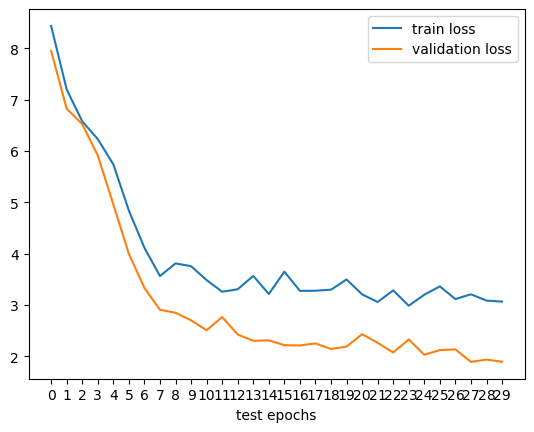

At last epoch, training loss: 3.0665
At last epoch, Validation loss: 1.8943
2/2 [==============================] - 0s 4ms/step


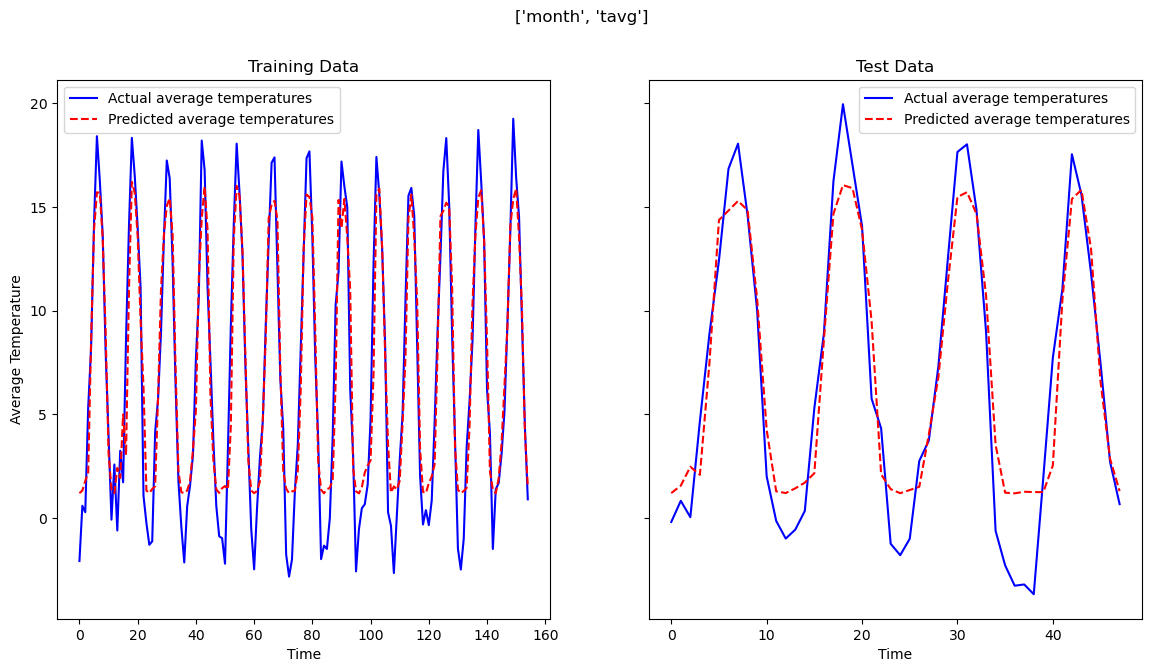

5/5 [==============================] - 0s 2ms/step - loss: 2.0917
Train Loss: 2.0917346477508545
2/2 [==============================] - 0s 4ms/step - loss: 2.3130
Test Loss: 2.313040018081665


In [24]:
model1 = train_and_evaluate_model(['month','tavg'], hidden_layer_sizes=[4],lstm_layer_sizes=[8,4], window_size=12, num_epochs=30, batch_size=8, learning_rate=0.01)


### Model 2: Month, Tavg, Prcp

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 12, 8)             384       
                                                                 
 dropout_2 (Dropout)         (None, 12, 8)             0         
                                                                 
 lstm_3 (LSTM)               (None, 4)                 208       
                                                                 
 dropout_3 (Dropout)         (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 617
Trainable params: 617
Non-trainable 

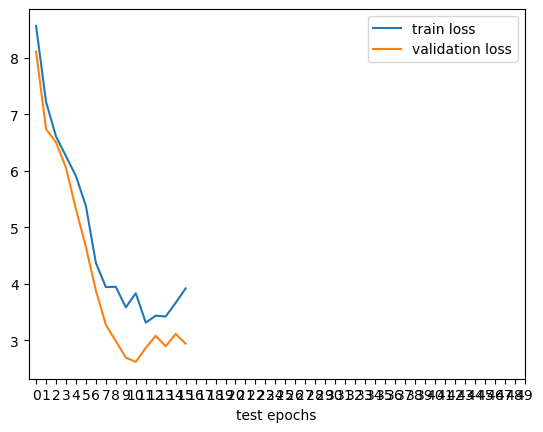

At last epoch, training loss: 3.9168
At last epoch, Validation loss: 2.9392
2/2 [==============================] - 0s 3ms/step


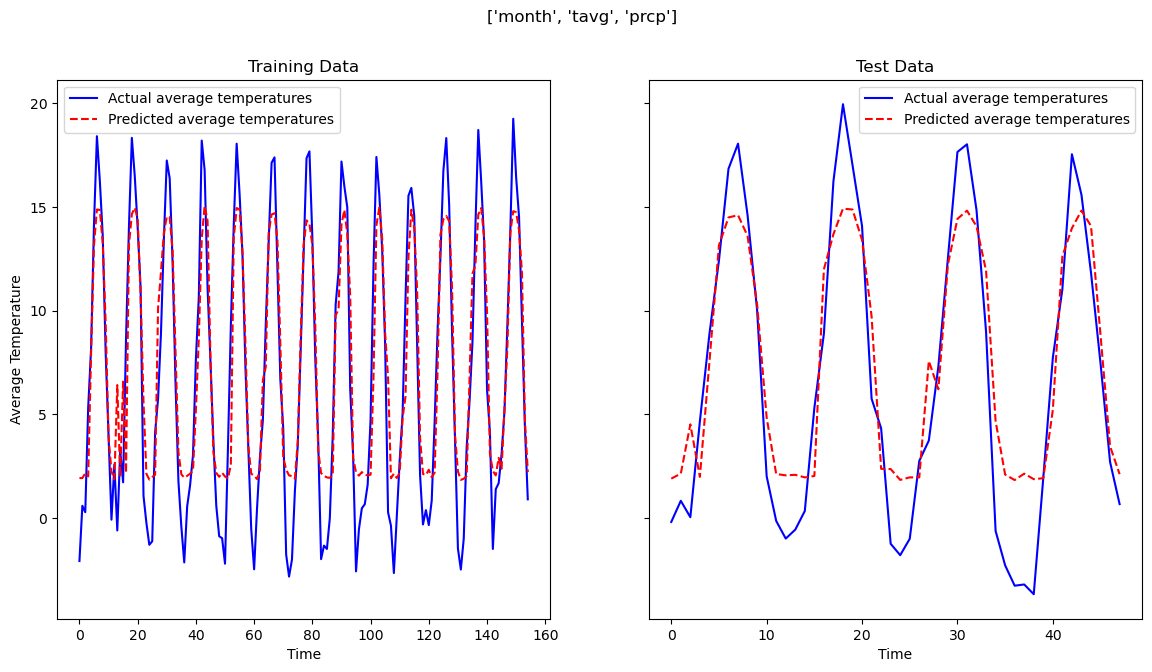

5/5 [==============================] - 0s 2ms/step - loss: 2.6125
Train Loss: 2.6124634742736816
2/2 [==============================] - 0s 3ms/step - loss: 2.9013
Test Loss: 2.901310682296753


In [25]:
model2 = train_and_evaluate_model(['month','tavg','prcp'], hidden_layer_sizes=[4],lstm_layer_sizes=[8,4], window_size=12, num_epochs=50, batch_size=8, learning_rate=0.01)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 12, 8)             416       
                                                                 
 dropout_4 (Dropout)         (None, 12, 8)             0         
                                                                 
 lstm_5 (LSTM)               (None, 4)                 208       
                                                                 
 dropout_5 (Dropout)         (None, 4)                 0         
                                                                 
 dense_4 (Dense)             (None, 4)                 20        
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 649
Trainable params: 649
Non-trainable 

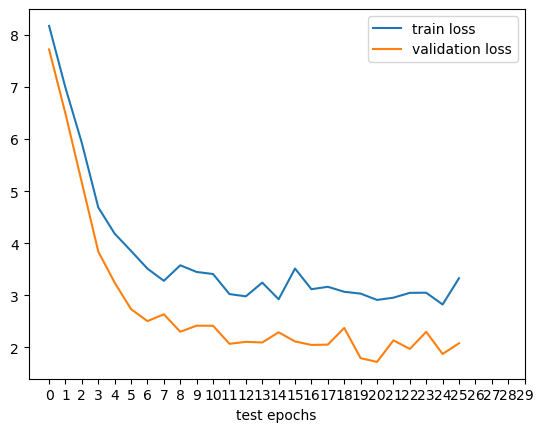

At last epoch, training loss: 3.3301
At last epoch, Validation loss: 2.0811
2/2 [==============================] - 0s 3ms/step


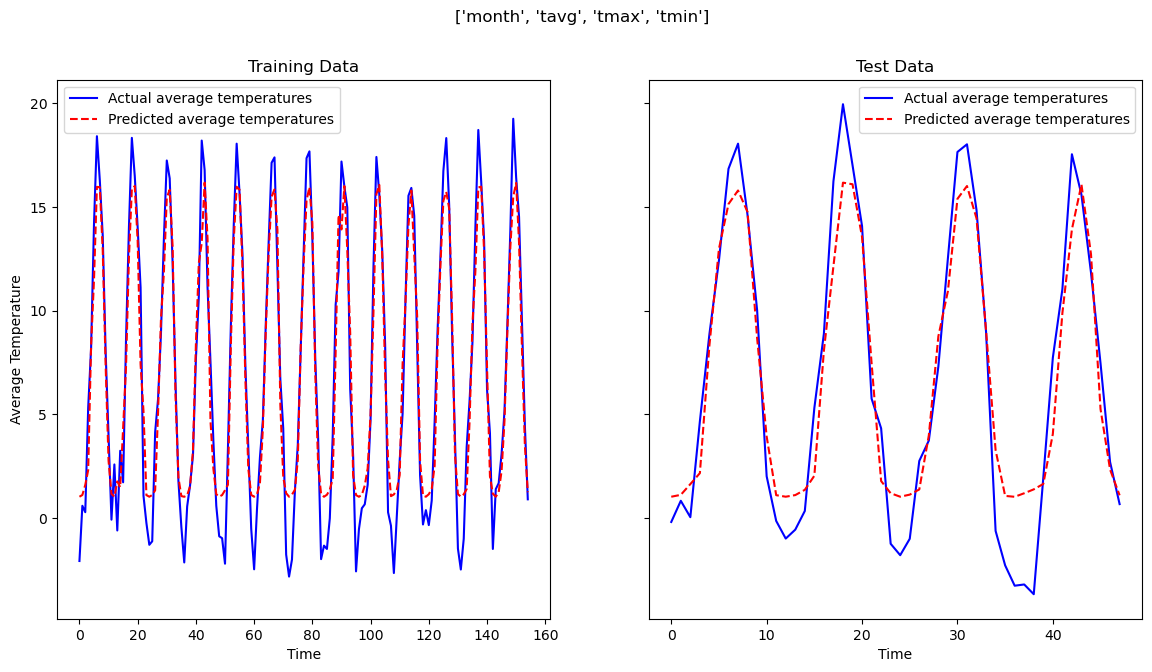

5/5 [==============================] - 0s 2ms/step - loss: 1.8080
Train Loss: 1.8080034255981445
2/2 [==============================] - 0s 3ms/step - loss: 2.2223
Test Loss: 2.222302198410034


In [26]:
model3_features=['month','tavg','tmax','tmin']
model3 = train_and_evaluate_model(model3_features, hidden_layer_sizes=[4],lstm_layer_sizes=[8,4], window_size=12, num_epochs=30, batch_size=8, learning_rate=0.01)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 12, 8)             448       
                                                                 
 dropout_6 (Dropout)         (None, 12, 8)             0         
                                                                 
 lstm_7 (LSTM)               (None, 4)                 208       
                                                                 
 dropout_7 (Dropout)         (None, 4)                 0         
                                                                 
 dense_6 (Dense)             (None, 4)                 20        
                                                                 
 dense_7 (Dense)             (None, 1)                 5         
                                                                 
Total params: 681
Trainable params: 681
Non-trainable 

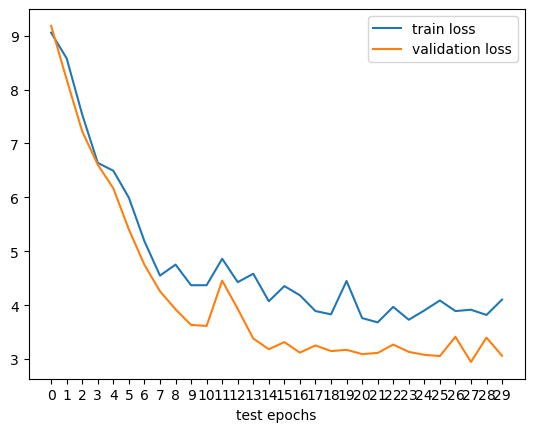

At last epoch, training loss: 4.1039
At last epoch, Validation loss: 3.0616
2/2 [==============================] - 0s 3ms/step


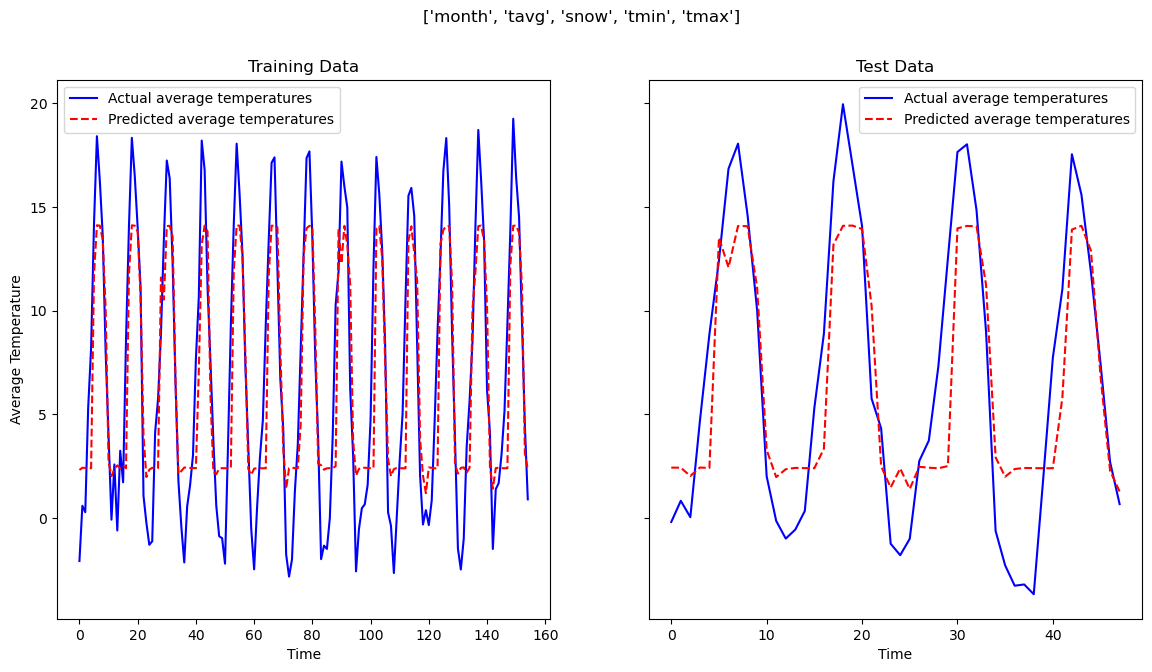

5/5 [==============================] - 0s 2ms/step - loss: 3.1190
Train Loss: 3.118973731994629
2/2 [==============================] - 0s 3ms/step - loss: 3.6543
Test Loss: 3.654329299926758


In [27]:
model4 = train_and_evaluate_model(['month','tavg','snow','tmin','tmax'], hidden_layer_sizes=[4],lstm_layer_sizes=[8,4], window_size=12, num_epochs=30, batch_size=8, learning_rate=0.01, loss='rmse')


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 24, 16)            1344      
                                                                 
 dropout_8 (Dropout)         (None, 24, 16)            0         
                                                                 
 lstm_9 (LSTM)               (None, 8)                 800       
                                                                 
 dropout_9 (Dropout)         (None, 8)                 0         
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,153
Trainable params: 2,153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
18/18 [==============================] -

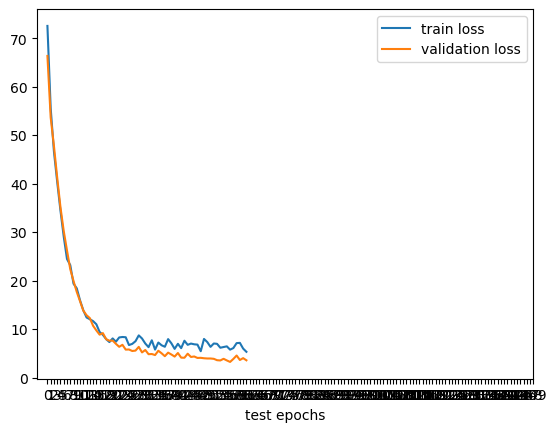

At last epoch, training loss: 5.3102
At last epoch, Validation loss: 3.5597
2/2 [==============================] - 0s 3ms/step


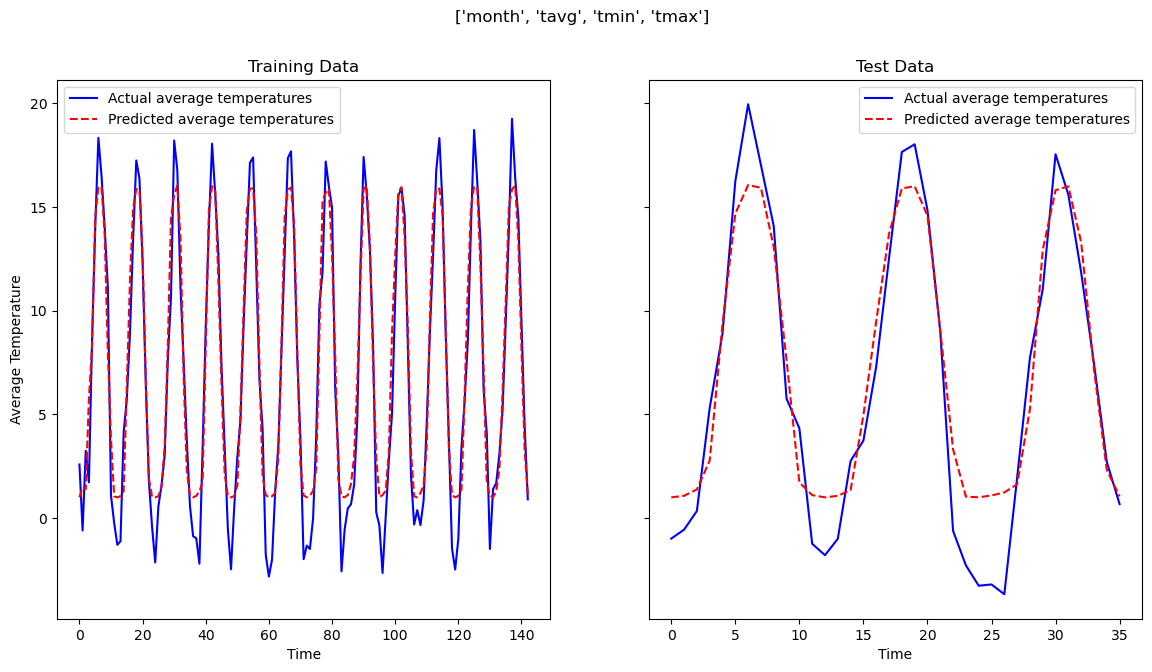

5/5 [==============================] - 1s 3ms/step - loss: 3.1375
Train Loss: 3.137507915496826
2/2 [==============================] - 0s 3ms/step - loss: 5.0295
Test Loss: 5.029480934143066


In [28]:
model5 = train_and_evaluate_model(['month','tavg','tmin','tmax'], hidden_layer_sizes=[],lstm_layer_sizes=[16,8], window_size=24, num_epochs=150, batch_size=8, learning_rate=0.005, loss='mse')


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 24, 16)            1408      
                                                                 
 dropout_10 (Dropout)        (None, 24, 16)            0         
                                                                 
 lstm_11 (LSTM)              (None, 8)                 800       
                                                                 
 dropout_11 (Dropout)        (None, 8)                 0         
                                                                 
 dense_9 (Dense)             (None, 8)                 72        
                                                                 
 dense_10 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,289
Trainable params: 2,289
Non-traina

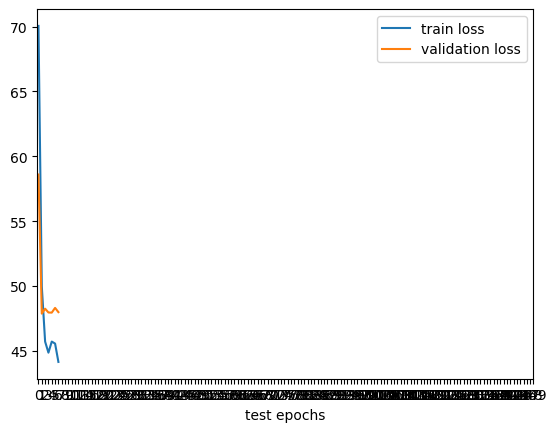

At last epoch, training loss: 44.1588
At last epoch, Validation loss: 47.9951
2/2 [==============================] - 0s 3ms/step


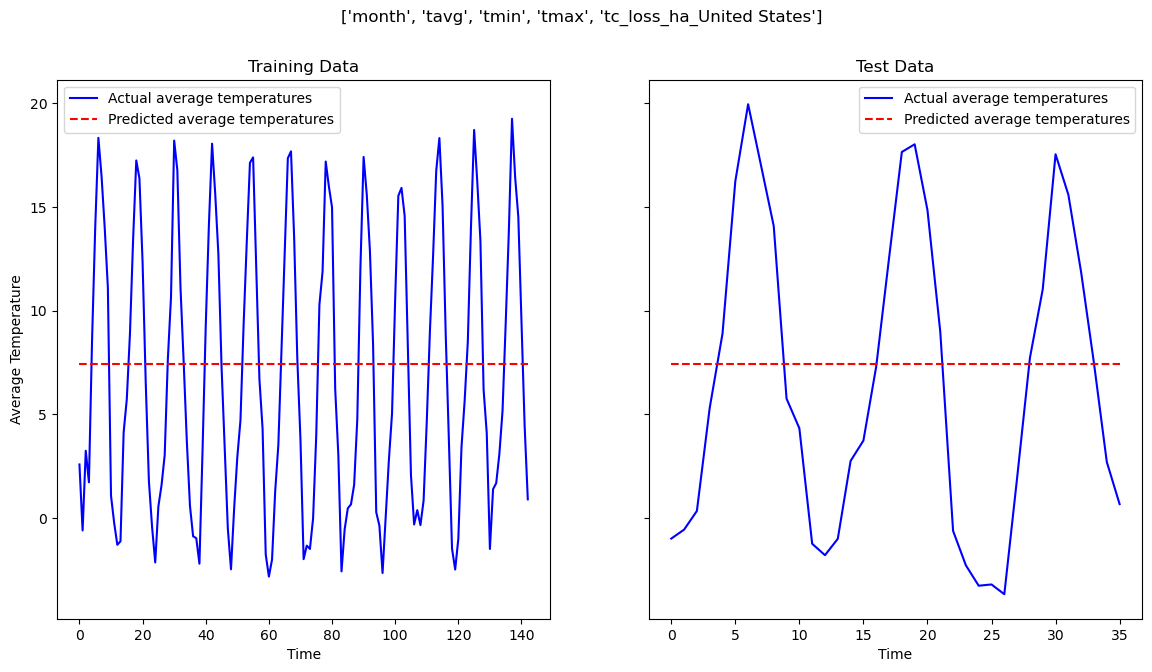

5/5 [==============================] - 1s 4ms/step - loss: 44.7916
Train Loss: 44.79160690307617
2/2 [==============================] - 0s 4ms/step - loss: 54.0554
Test Loss: 54.055362701416016


In [29]:
model6 = train_and_evaluate_model(['month','tavg','tmin','tmax','tc_loss_ha_United States'], hidden_layer_sizes=[8],lstm_layer_sizes=[16,8], window_size=24, num_epochs=150, batch_size=8, learning_rate=0.01, loss='mse')


2/2 [==============================] - 0s 2ms/step
prediction [[ 1.0354079]
 [ 1.1268553]
 [ 1.6440219]
 [ 2.171288 ]
 [ 8.327136 ]
 [12.977594 ]
 [15.133543 ]
 [15.785219 ]
 [14.749928 ]
 [ 8.671618 ]
 [ 3.935675 ]
 [ 1.1095473]
 [ 1.0367211]
 [ 1.1144737]
 [ 1.3672951]
 [ 2.0470097]
 [ 8.0734825]
 [12.137891 ]
 [16.162949 ]
 [16.08537  ]
 [13.5476   ]
 [ 7.468086 ]
 [ 1.7915009]
 [ 1.2031193]
 [ 1.036595 ]
 [ 1.1366583]
 [ 1.3862762]
 [ 3.9882782]
 [ 8.761222 ]
 [10.938139 ]
 [15.381571 ]
 [16.000443 ]
 [14.444821 ]
 [ 9.032217 ]
 [ 3.2815046]
 [ 1.0754082]
 [ 1.0330565]
 [ 1.203469 ]
 [ 1.3909667]
 [ 1.6513261]
 [ 4.056907 ]
 [ 9.871853 ]
 [13.912839 ]
 [16.076754 ]
 [12.715374 ]
 [ 5.256071 ]
 [ 2.3455734]
 [ 1.1036898]]
Mean Absolute Error (MAE): 1.8434060873587927
Mean Squared Error (MSE): 5.095432238407702
Root Mean Squared Error (RMSE): 2.2573064121664346


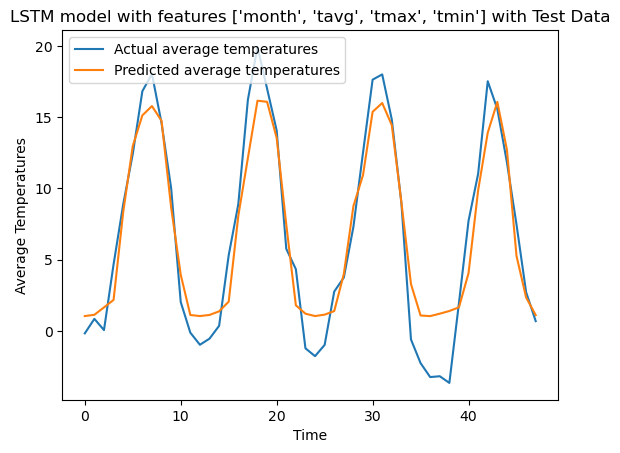

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

selected_features = model3_features
X_seq_test, y_seq_test = create_sequences(test, window_size=12,seq_features=selected_features,target_variable='tavg')

# Predict temperatures using the trained model
predictions = model3.predict(X_seq_test)
print("prediction", predictions)

# Calculate evaluation metrics
mae = mean_absolute_error(y_seq_test, predictions)
mse = mean_squared_error(y_seq_test, predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

plot_predictions(y_seq_test, predictions,"Time","Average Temperatures","LSTM model with features {} with Test Data".format(selected_features))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 36, 16)            1344      
                                                                 
 dropout_16 (Dropout)        (None, 36, 16)            0         
                                                                 
 lstm_17 (LSTM)              (None, 8)                 800       
                                                                 
 dropout_17 (Dropout)        (None, 8)                 0         
                                                                 
 dense_15 (Dense)            (None, 4)                 36        
                                                                 
 dense_16 (Dense)            (None, 1)                 5         
                                                                 
Total params: 2,185
Trainable params: 2,185
Non-traina

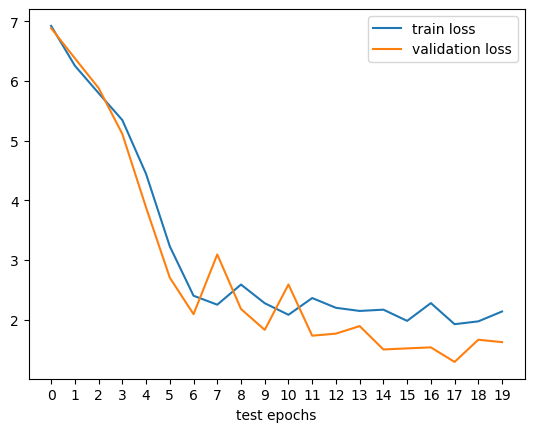

At last epoch, training loss: 2.1348
At last epoch, Validation loss: 1.6209
1/1 [==============================] - 0s 24ms/step


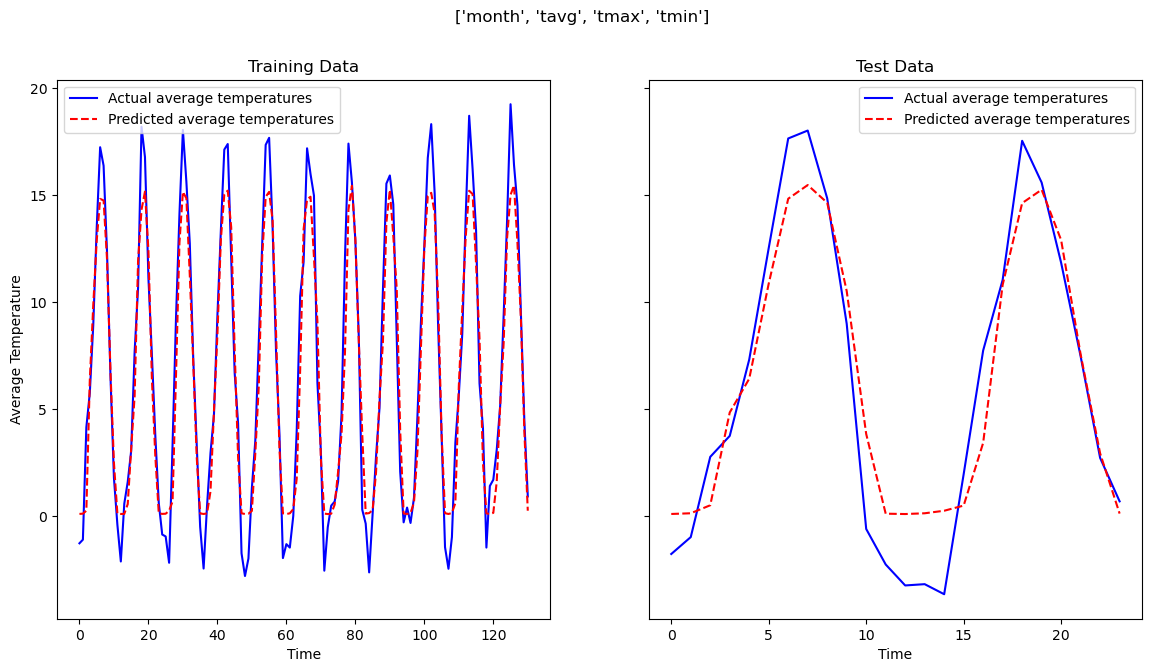

5/5 [==============================] - 0s 4ms/step - loss: 1.4044
Train Loss: 1.4044182300567627
1/1 [==============================] - 0s 24ms/step - loss: 1.8567
Test Loss: 1.8566689491271973


In [33]:
model7_features=['month','tavg','tmax','tmin']
model7 = train_and_evaluate_model(model7_features, hidden_layer_sizes=[4],lstm_layer_sizes=[16,8], window_size=36, num_epochs=20, batch_size=16, learning_rate=0.01,loss='mae')
